In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Linear and Logistic Regression

- Regression is a technique for supervised learning that is based on strong statistical assumptions about the underlying data. Linear and logistic regression are just two different assumptions on the data
- Regression can be used when the assumptions are not met, but then it needs to be graded based on _performance on the test data_. P-values, F-scores, etc.. depend on the assumptions being true.

## Linear Regression

Let $y \in \mathbb{R}$ be a random variable (the target) and $X = x_1, \ldots, x_p$ be a set of _independent_ variables (the predictors). Then
$$
y \sim \cal{N}(\mu, \sigma)
$$
where 
$$
\mu = \mu(X) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_p x_p
$$

### Linear Regression Test Data

Let's generate some sample data that matches the assumptions exactly.

1. Set p = 3
2. Choose a formula for $\mu(X)$
$$
\mu(X) = 5 - 9 x_1 + 3 x_2 + 2 x_3
$$

Features

In [28]:
p = 3
X = pd.DataFrame(np.random.rand(100, p))

In [29]:
X.head()

,0,1,2
0,0.076883,0.817245,0.722774
1,0.484117,0.156508,0.670622
2,0.571817,0.507034,0.705738
3,0.852782,0.127106,0.482410
4,0.264576,0.672684,0.692478


The target is a linear function of the features, plus some gaussian noise.

In [30]:
sigma = .1
def make_target(row, sigma):
    x, y, z = row[0], row[1], row[2]
    return np.random.normal(5 - 9*x + 3*y + 2*z, sigma)
X['target'] = X.apply(lambda row: make_target(row, sigma), 1)


In [31]:
X.head()

,0,1,2,target
0,0.076883,0.817245,0.722774,8.332641
1,0.484117,0.156508,0.670622,2.582635
2,0.571817,0.507034,0.705738,2.579320
3,0.852782,0.127106,0.482410,-1.038786
4,0.264576,0.672684,0.692478,6.065245


### Recover the formula using linear regression

Intercept: 4.95
Coeffs:  [-8.96444748  2.9880128   2.08387353]
R-squared: 0.999


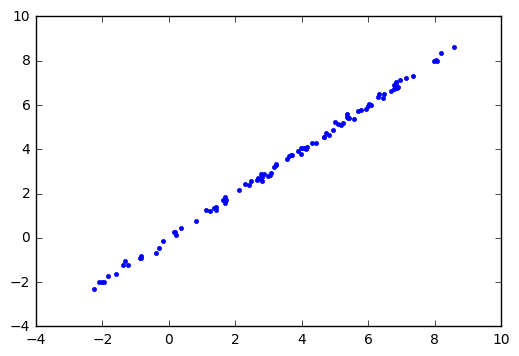

In [32]:
from sklearn.linear_model import LinearRegression

# Fit model
linreg = LinearRegression()
linreg.fit(X.iloc[:,:-1], X['target'])

print 'Intercept: {:.3}'.format(linreg.intercept_)

print 'Coeffs: ', linreg.coef_

print 'R-squared: {:.3}'.format(linreg.score(X.iloc[:, :-1], X['target']))

# Plot predicted vs actual
pred = linreg.predict(X.iloc[:,:-1])
plt.plot(pred, X['target'], '.')

## Logistic Regression

Let $y \in \{0, 1\}$ be a random variable (the target) and $X = x_1, \ldots, x_p$ be a set of _independent_ variables (the predictors). Then
$$
y \sim \cal{Ber}(p)
$$
where
$$
p = p(X) = f(w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_p x_p)
$$
and $f$ is the _logistic function_
$$
f(t) = \frac{1}{1 + e^{-t}}
$$

### Logistic Regression Test Data

Let's generate some sample data that matches the assumptions exactly.

1. Set p = 3
2. Choose a formula for $p(X)$
$$
p(X) = f(5 - 9 x_1 + 3 x_2 + 2 x_3)
$$

#### Exercise: Generate logistic regression data according to the model above.

In [33]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def make_target_logistic(row):
    """
    Return either 0 or 1, according to a Bernoulli distribution defined by row.
    """
    x, y, z = row[0], row[1], row[2]
    p = sigmoid(5 - 9*x + 3*y + 2*z)
    return np.random.binomial(1, p)

X['target'] = X.apply(lambda row: make_target_logistic(row), 1)

#### Recover coefficients

In [34]:
from sklearn.linear_model import LogisticRegression

# Fit logistic model
logit = LogisticRegression(C=1e18)
logit.fit(X.iloc[:,:-1], X['target'])

print 'Intercept: {:.3}'.format(logit.intercept_)

print 'Coeffs: ', logit.coef_

print 'Accuracy: {:.3}'.format(logit.score(X.iloc[:, :-1], X['target']))

Intercept: [ 6
Coeffs:  [[-12.42471417   5.30521971   1.77775537]]
Accuracy: 0.92


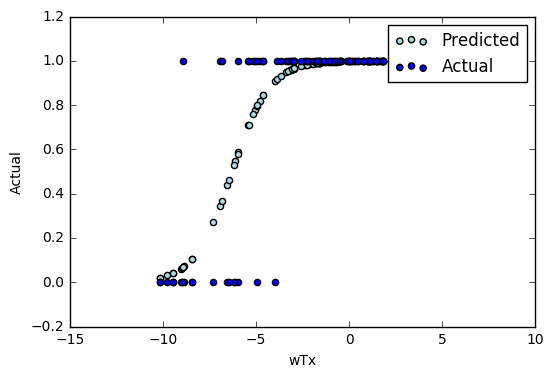

In [35]:
results = pd.DataFrame({
        'wTx': X.apply(lambda row: np.dot(row[:3], logit.coef_.flatten()), axis=1),
        'Predicted Probability': logit.predict_proba(X.iloc[:, :-1])[:,1],
        'Actual': X['target']
    })

ax = results.plot(x='wTx', y='Predicted Probability', kind='scatter', 
                  label = 'Predicted', color='lightblue')
results.plot(x='wTx', y='Actual', kind='scatter', ax=ax, label='Actual')

# Regularization

For any type of regression, one learns the model parameters by:

1. Assume the probabilistic model is correct.
2. Compute the _likelihood_ of each data point for a given set of parameters $w_0, \ldots, w_p$. (just evaluate the PDF at that point and target value)
3. Choose the set of parameters that minimizes the total likelihood.

For linear regression, it turns out that ${\cal L} (X) \sim -||w^T x - y||^2$. So maximizing the likelihood is the same as minimizing the mean-squared error.

For logistic regression,
$$
{\cal L} (x) := -y \log(f(w^T x)) - (1 - y) \log(1 - f(w^Tx))
$$

In either case, regularization just means that instead of directly minimizing ${\cal L}(X)$, we also add a penalty on the size of coefficients.

#### L1 (Lasso) Regularization

Find $w$ that minimizes 
$$
{\cal L}(X) + \lambda \sum_{i=1}^p |w_i|
$$

#### L2 (Ridge) Regularization

Find $w$ that minimizes 
$$
{\cal L}(X) + \lambda \sum_{i=1}^p ||w_i||^2
$$

#### Elastic Net Regularization

Find $w$ that minimizes 
$$
{\cal L}(X) + (1 - \alpha) \cdot \lambda \sum_{i=1}^p |w_i|^2 + \alpha \cdot \lambda \sum_{i=1}^p ||w_i||
$$

# Application: Crime Data

In [36]:
from sklearn.model_selection import train_test_split

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
         .iloc[:, 5:]
         .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
train_df, test_df = train_test_split(crime, random_state=2)

In [37]:
train_df.shape

(239, 122)

In [38]:
test_df.shape

(80, 122)

## Exercise: 

1. Fit a linear regression model on train_df. The goal is to predict 'ViolentCrimesPerPop' from the other columns. What is the r-squared on the train data? What about the test data?
2. Also fit each of a ridge, lasso, and elastic net regression on the same data. Use the functions RidgeCV, LassoCV, and ElasticNetCV to cross-validate and find the best values of $\lambda$ and $\alpha$.
3. Which model performs the best?

### Linear Regression

In [39]:
linreg = LinearRegression()
linreg.fit(train_df[predictors], train_df[target])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
print 'Train R-squared: {:.3}'.format(linreg.score(train_df[predictors], train_df[target]))
print 'Test R-squared: {:.3}'.format(linreg.score(test_df[predictors], test_df[target]))

Train R-squared: 0.823
Test R-squared: 0.509


### Ridge

In [41]:
2. ** np.arange(-10, 10)

array([  9.76562500e-04,   1.95312500e-03,   3.90625000e-03,
         7.81250000e-03,   1.56250000e-02,   3.12500000e-02,
         6.25000000e-02,   1.25000000e-01,   2.50000000e-01,
         5.00000000e-01,   1.00000000e+00,   2.00000000e+00,
         4.00000000e+00,   8.00000000e+00,   1.60000000e+01,
         3.20000000e+01,   6.40000000e+01,   1.28000000e+02,
         2.56000000e+02,   5.12000000e+02])

In [45]:
from sklearn.linear_model import RidgeCV

# ridge = RidgeCV(alphas= 2. ** np.arange(-10, 10))
ridge = RidgeCV(alphas= np.linspace(5, 50, 100))
ridge.fit(train_df[predictors], train_df[target])

RidgeCV(alphas=array([  5.     ,   5.45455, ...,  49.54545,  50.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [46]:
ridge.alpha_

11.818181818181818

In [47]:
print 'Train R-squared: {:.3}'.format(ridge.score(train_df[predictors], train_df[target]))
print 'Test R-squared: {:.3}'.format(ridge.score(test_df[predictors], test_df[target]))

Train R-squared: 0.661
Test R-squared: 0.713


### Lasso

In [48]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(alphas= 2. ** np.arange(-10, 10))
lasso.fit(train_df[predictors], train_df[target])

LassoCV(alphas=array([  9.76562e-04,   1.95312e-03,   3.90625e-03,   7.81250e-03,
         1.56250e-02,   3.12500e-02,   6.25000e-02,   1.25000e-01,
         2.50000e-01,   5.00000e-01,   1.00000e+00,   2.00000e+00,
         4.00000e+00,   8.00000e+00,   1.60000e+01,   3.20000e+01,
         6.40000e+01,   1.28000e+02,   2.56000e+02,   5.12000e+02]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [49]:
print 'Train R-squared: {:.3}'.format(lasso.score(train_df[predictors], train_df[target]))
print 'Test R-squared: {:.3}'.format(lasso.score(test_df[predictors], test_df[target]))

Train R-squared: 0.661
Test R-squared: 0.722


### Elastic Net

In [50]:
from sklearn.linear_model import ElasticNetCV
en = ElasticNetCV(l1_ratio=np.linspace(.05, .95, 20), alphas= 2. ** np.arange(-10, 10))
en.fit(train_df[predictors], train_df[target])

ElasticNetCV(alphas=array([  9.76562e-04,   1.95312e-03,   3.90625e-03,   7.81250e-03,
         1.56250e-02,   3.12500e-02,   6.25000e-02,   1.25000e-01,
         2.50000e-01,   5.00000e-01,   1.00000e+00,   2.00000e+00,
         4.00000e+00,   8.00000e+00,   1.60000e+01,   3.20000e+01,
         6.40000e+01,   1.28000e+02,   2.56000e+02,   5.12000e+02]),
       copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.05   ,  0.09737,  0.14474,  0.19211,  0.23947,  0.28684,
        0.33421,  0.38158,  0.42895,  0.47632,  0.52368,  0.57105,
        0.61842,  0.66579,  0.71316,  0.76053,  0.80789,  0.85526,
        0.90263,  0.95   ]),
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [51]:
print 'Train R-squared: {:.3}'.format(en.score(train_df[predictors], train_df[target]))
print 'Test R-squared: {:.3}'.format(en.score(test_df[predictors], test_df[target]))

Train R-squared: 0.655
Test R-squared: 0.721


## Exercise:

1. Make the following scatterplot
    - Each point corresponds to one predictor in the data
    - The x-value is the coefficient of that predictor under OLS regression
    - The y-value is the coefficient of that predictor using ridge regularization
2. Do the same for OLS vs Lasso, and OLS vs ElasticNet

In [52]:
coeffs = pd.DataFrame({
        'OLS': linreg.coef_,
        'Ridge': ridge.coef_,
        'Lasso': lasso.coef_,
        'ElasticNet': en.coef_
    })

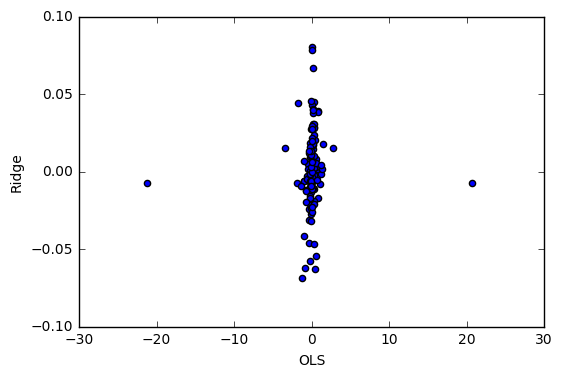

In [53]:
coeffs.plot(x='OLS', y='Ridge', kind='scatter')

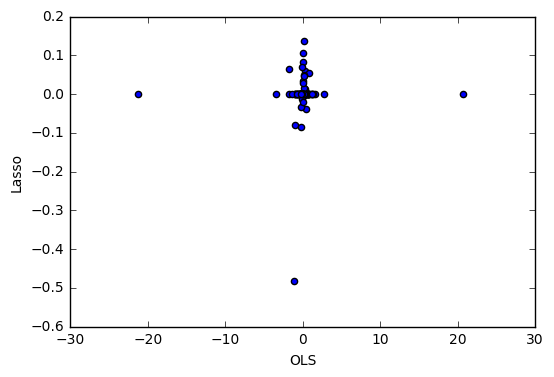

In [54]:
coeffs.plot(x='OLS', y='Lasso', kind='scatter')

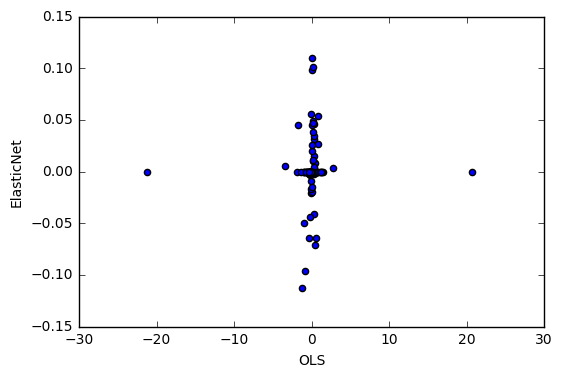

In [55]:
coeffs.plot(x='OLS', y='ElasticNet', kind='scatter')

## Question: 

What is the story with the two 'large coefficients' found by OLS that are squashed by regularization? (You may have to do some digging)

    PolicPerPop  LemasSwFTPerPop
8          0.13             0.13
36         0.30             0.30
6          0.08             0.08
12         0.16             0.16
19         0.11             0.11


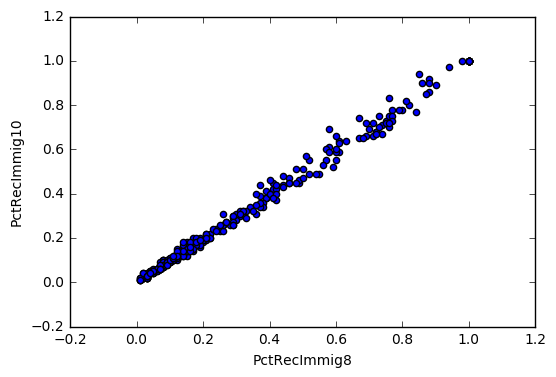

In [56]:
# Get index of largest two coefficients, in absolute value
idx = np.argsort(np.abs(linreg.coef_))[-2:]

# Get the predictor names
offenders = [predictors[i] for i in idx]

# Take a look
print crime[offenders].head()
crime.plot(x='PctRecImmig8', y='PctRecImmig10', kind='scatter')

They are almost perfectly correlated. OLS was learning a large positive coefficient for one and canceling it out with the coefficient of the other.

## Question:

Can we tell from this process which predictors are _the most important_ for predicting violent crimes?

Answer: Not really. It's tempting to pick the largest coefficients from the regularized model and say that these are the most important features, but there are a couple of caveats:

1. None of the features have been normalized (that we know of). For example, suppose some model has a distance as one of the predictors. The coefficient of that feature will be very different if the distance is measured in inches rather than meters.
2. Some of the predictors may be correlated (we have already seen that some are). So there may be some feature that is highly correlated with violent crimes, but it is is also well 'predicted' by another feature in the data, so its coefficient is set to zero.